In [50]:
import os
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt

# Répertoire contenant les fichiers HOBO
dossier_hobo = r"C:\Users\vincent.destaerc\Documents\GitHub\Yverdon_les_tropiques\Fichiers Hobo"
os.chdir(dossier_hobo)
print("Nouveau répertoire courant :", os.getcwd())

def charger_donnees_hobo(chemin_dossier):
    li = []
    all_files = glob.glob(os.path.join(chemin_dossier, "*.csv"))
    if not all_files:
        print(f"No CSV files found in {chemin_dossier}.")
        return pd.DataFrame()

    for filename in all_files:
        # Lire en sautant la première ligne (ligne 0) et sans utiliser le header du fichier
        df = pd.read_csv(filename, skiprows=2, header=None, sep=',')
        # Renommer les colonnes
        df = df.rename(columns={1: 'timestamp', 2: 'temperature', 3: 'humidity'})
        # Garder uniquement les colonnes utiles
        df = df[['timestamp', 'temperature', 'humidity']]
        # Extraire le nom de la station
        station_name = os.path.basename(filename).replace("Yverdon_les_Tropiques_", "").replace(".csv", "").replace("_", " ").strip()
        df['station'] = station_name
        li.append(df)

    frame = pd.concat(li, axis=0, ignore_index=True)
    return frame

df_hobo = charger_donnees_hobo(dossier_hobo)
print(df_hobo.head())

Nouveau répertoire courant : C:\Users\vincent.destaerc\Documents\GitHub\Yverdon_les_tropiques\Fichiers Hobo
              timestamp  temperature  humidity    station
0  06/10/25 10:00:00 AM       24.653    47.546  Haldimand
1  06/10/25 10:10:00 AM       24.532    47.979  Haldimand
2  06/10/25 10:20:00 AM       24.339    48.178  Haldimand
3  06/10/25 10:30:00 AM       24.195    48.607  Haldimand
4  06/10/25 10:40:00 AM       24.002    49.920  Haldimand


C:\Users\vincent.destaerc\AppData\Local\Temp\ipykernel_17540\2465155075.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['timestamp'])


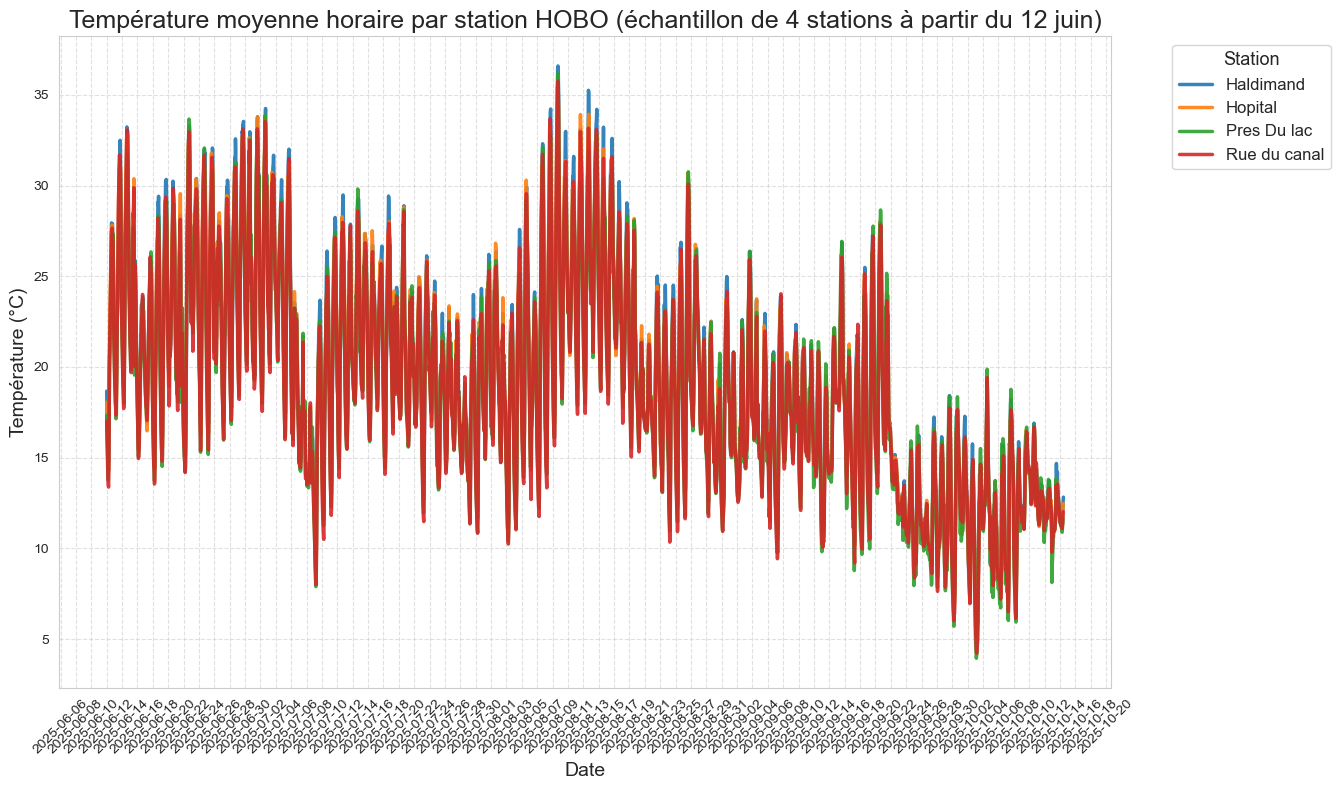

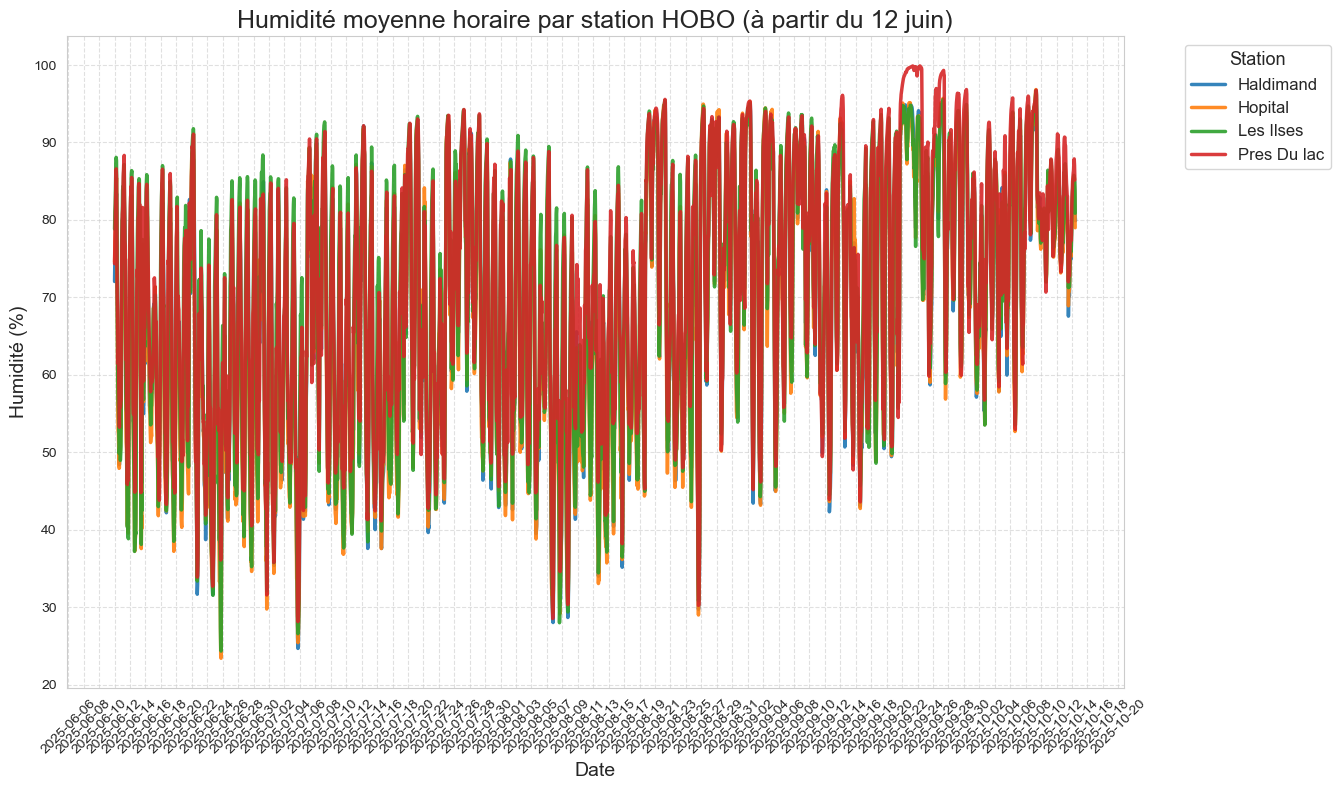

✅ Fichier 'C:\Users\vincent.destaerc\Documents\GitHub\Yverdon_les_tropiques\Export csv\hobo_moyennes_horaires.csv' exporté avec succès.


In [51]:

# Prétraitement pour extraire les colonnes timestamp, temperature, humidity
def preprocess_hobo_df(df):
    # Ignore header rows
    df = df[~df[0].str.startswith('#')]
    # Split the string into columns
    split_df = df[0].str.split(',', expand=True)
    # Remove index column if present
    if split_df.shape[1] == 4:
        split_df = split_df.iloc[:, 1:]
    split_df.columns = ['timestamp', 'temperature', 'humidity']
    # Clean up and convert types
    split_df['timestamp'] = pd.to_datetime(split_df['timestamp'], format='%m/%d/%y %I:%M:%S %p')
    split_df['temperature'] = pd.to_numeric(split_df['temperature'], errors='coerce')
    split_df['humidity'] = pd.to_numeric(split_df['humidity'], errors='coerce')
    # Add station column back
    split_df['station'] = df['station'].values
    return split_df

# Calcul des moyennes horaires
def calculer_moyenne_horaire_hobo(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['heure'] = df['timestamp'].dt.floor('h')
    moyennes = df.groupby(['station', 'heure'])[['temperature', 'humidity']].mean().reset_index()
    return moyennes

# Calcul sur le DataFrame chargé par la cellule 1
if not df_hobo.empty:
    moyennes_hobo = calculer_moyenne_horaire_hobo(df_hobo)
else:
    moyennes_hobo = pd.DataFrame()

# Exemple de visualisation
import matplotlib.dates as mdates
import numpy as np

start_date = '2025-06-12'
filtered_moyennes_hobo = moyennes_hobo[moyennes_hobo['heure'] >= start_date].copy()

def plot_time_series_hobo(data, y_var, y_label, title, sample_stations=None, figsize=(16, 8)):
    if sample_stations is not None:
        stations_unique = data['station'].unique()
        if sample_stations < len(stations_unique):
            sampled = np.random.choice(stations_unique, size=sample_stations, replace=False)
            data = data[data['station'].isin(sampled)]

    plt.figure(figsize=figsize)
    sns.set_style("whitegrid")
    palette = sns.color_palette("tab10", n_colors=data['station'].nunique())

    ax = sns.lineplot(
        data=data,
        x='heure',
        y=y_var,
        hue='station',
        linewidth=2.5,
        alpha=0.9,
        palette=palette
    )
    ax.set_title(title, fontsize=18)
    ax.set_xlabel("Date", fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(title='Station', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=13)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

# Exemple d’appel pour un échantillon de 4 stations (température)
plot_time_series_hobo(
    filtered_moyennes_hobo,
    y_var='temperature',
    y_label='Température (°C)',
    title="Température moyenne horaire par station HOBO (échantillon de 4 stations à partir du 12 juin)",
    sample_stations=4
)

# Tracer toutes les stations pour l'humidité
plot_time_series_hobo(
    filtered_moyennes_hobo,
    y_var='humidity',
    y_label='Humidité (%)',
    title="Humidité moyenne horaire par station HOBO (à partir du 12 juin)",
    sample_stations=4
)

# Export CSV
output_dir = r"C:\Users\vincent.destaerc\Documents\GitHub\Yverdon_les_tropiques\Export csv"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "hobo_moyennes_horaires.csv")
moyennes_hobo.to_csv(output_path, index=False, sep=";")
print(f"✅ Fichier '{output_path}' exporté avec succès.")